# Programma che esegue il fit per 3 componenti (SVD):

Per prima cosa è necessario andare a creare la matrice ridotta con sklearn da cui, passandogli il n° di componenti che vuoi, puoi ricavarti i nuovi vettori che saranno:
- U'= $U \cdot S$;
- V'= $V^T$

In [34]:
from sklearn.decomposition import TruncatedSVD
import numpy as np
import pandas as pd

# Carica il DataFrame
df = pd.read_csv('dati_puliti.csv', sep='\t', header=None)

# Funzione per ridurre con SVD
def riduci_svd(matrice, n_componenti):
    svd = TruncatedSVD(n_components=n_componenti)
    U_prime = svd.fit_transform(matrice)  # U'
    V_prime = svd.components_             # V'
    return U_prime, V_prime

# Applica la funzione
U_prime, V_prime = riduci_svd(df, 3)

Ora al fine di fare un fit globale, visto che i parametri in gioco sono molti è necessario fare delle consideraizoni.
L'obiettivo è quello di fare un fit globale delle prime n componenti $V'_i$ con le funzioni $f_i(x)$;
- Dove $f_i(x)= C_{i1} \cdot M_1(x) + C_{i2} \cdot M_2(x) + C_{i3} \cdot M_3(x)$ (Nel caso si abbiano 3 componenti principali).
e, di nuovo, $M_i(x)$ sono le equazioni di Van't Hoff, definite in questo modo (solo numeratore):
1) $ M_{1} = 1 $
2) $ M_{2} = exp(- \frac {\Delta H_{1}} {R}) \cdot ((\frac{1}{T_{m1}}- \frac {1}{T})$
3) $ M_{3} = exp(- \frac {\Delta H_{2}} {R}) \cdot ((\frac{1}{T_{m2}}- \frac {1}{T})$

Questo risulta come ho accennato complicato e perciò si ricorre ad un trucco per fissare alcuni parametri; 
Se nel caso in esempio le componenti principali sono 3 (e di conseguenza gli stati del G4 sono 3 F<->I<->U) allora il numero di coefficienti da fissare sarà 12: 
- 2 Tm;
- 2 $ \Delta H$;
- 9 coefficienti $C_{ij}$;

Quindi avendo a disposizione lo spettro F (a T più bassa), e quello U (a T più alta) si esegue un fit locale della forma generale di U' sullo spettro:
$$Spettro_{F,20°}= C_{11} \cdot U_1 + C_{21} \cdot U_2 + C_{31} \cdot U_3$$

$$Spettro_{U,90°}= C_{13} \cdot U_1 + C_{23} \cdot U_2 + C_{33} \cdot U_3$$

In questo modo riusciremo a tenere fissi 4 (6) coefficienti che renderanno il fit globale più semplice.

Tiriamoci fuori i vettori U' e V', intanto:

In [35]:
print("U' :")
print(U_prime[:5])  # prime 5 righe, tutte le colonne

print("\nV' :")
print(V_prime[:, :5])  # tutte le righe (componenti), prime 5 colonne

U' :
[[ 100.0688664  -116.97144266  -11.11278986]
 [   3.0809891    -1.053795      0.37979123]
 [   3.0659904    -1.05133536    0.3862295 ]
 [   3.05836842   -1.07736631    0.39921365]
 [   3.05554134   -1.07246129    0.41819604]]

V' :
[[ 0.29544978  0.29416767  0.28936367  0.28039504  0.26888576]
 [ 0.26032992  0.24861326  0.23428068  0.21761431  0.19392005]
 [-0.17578438 -0.17646527 -0.14586586 -0.11807121 -0.07295672]]


Ora andiamo a fittare la forma di U con lo spettro:


Coefficenti:
C11: 0.29382419049541314, C21: 0.25905508927858456, C31: -0.1767422672593582


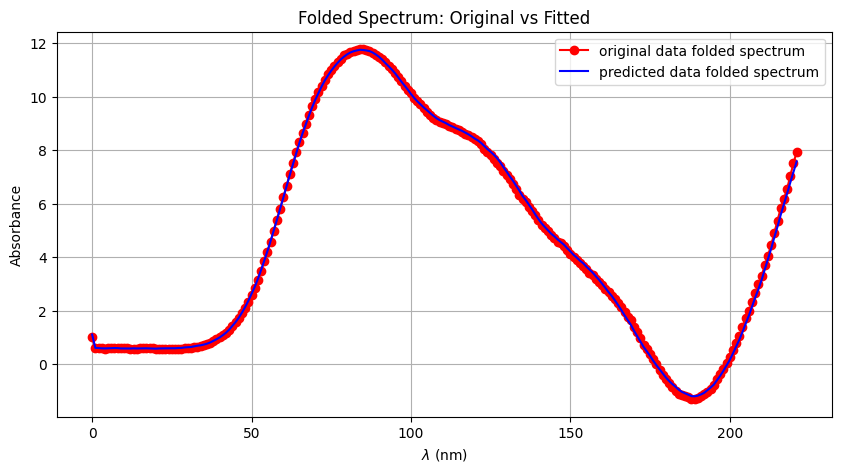

In [36]:
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot as plt
spttr_F = df.iloc[:, 0].values # prima colonna (spettro folded)
reg = LinearRegression()
reg.fit(U_prime, spttr_F)  # addestra il modello
C11,C21,C31 = reg.coef_  # coefficenti
print("\nCoefficenti:")
print(f"C11: {C11}, C21: {C21}, C31: {C31}")

plt.figure(figsize=(10, 5))
plt.plot(spttr_F, label= 'original data folded spectrum', marker='o', color='red')
plt.plot(reg.predict(U_prime), label= 'predicted data folded spectrum', linestyle='-', color='blue')
plt.title('Folded Spectrum: Original vs Fitted')
plt.xlabel(r'$\lambda$ (nm)')
plt.ylabel('Absorbance')
plt.grid(True)
plt.legend()
plt.show()


Coefficenti:
C13: 0.12443439271290939, C23: -0.22288673756368296, C33: -0.21503112553571269


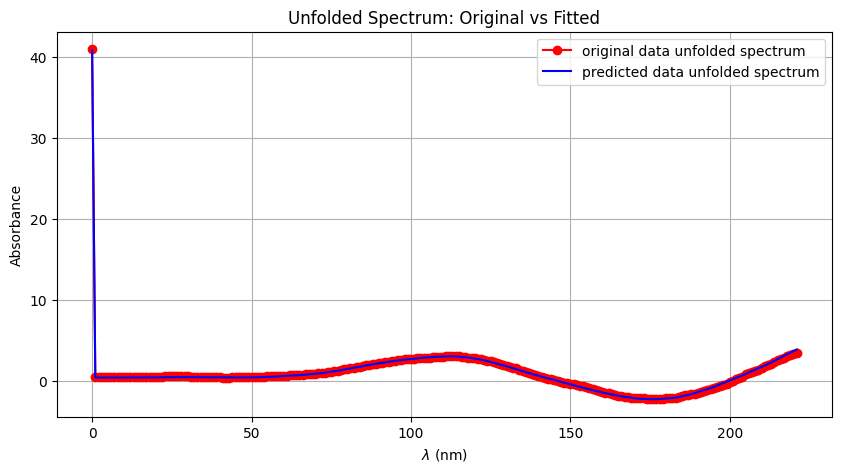

In [37]:
spttr_U = df.iloc[:, -1].values # ultima colonna (spettro unfolded)
reg.fit(U_prime, spttr_U)  # addestra il modello
C13,C23,C33 = reg.coef_  # coefficenti
print("\nCoefficenti:")
print(f"C13: {C13}, C23: {C23}, C33: {C33}")

plt.figure(figsize=(10, 5))
plt.plot(spttr_U, label= 'original data unfolded spectrum', marker='o', color='red')
plt.plot(reg.predict(U_prime), label= 'predicted data unfolded spectrum', linestyle='-', color='blue')
plt.title('Unfolded Spectrum: Original vs Fitted')
plt.xlabel(r'$\lambda$ (nm)')
plt.ylabel('Absorbance')
plt.grid(True)
plt.legend()
plt.show()

Ora abbiamo i primi 4 (6) coefficienti.
Ci resta solamente da fare il fit globale grazie alle funzioni di Van't Hoff.

In [38]:
# Creazione array per le temperature
t_csv = pd.read_csv('matrice_con_t.dat', sep='\t', header=None)
t_array = t_csv.iloc[0, 1:].astype(float).values # prima riga, da 2 in poi
T_kelvin = t_array + 273.15

R = 1.987  # cal/(mol·K)

print("\nTemperatura (K):")
print(T_kelvin[:5])  # prime 5 righe


Temperatura (K):
[293.15 295.15 297.15 299.15 301.15]


Qui è stato fatto un global-fit per il modello F<->I<->U.
In cui è ovviamante presente uno stadio intermedio tra la conformazione Folded and Unfolded. 

In [39]:
def calc_M_2p(T, Tm1, Tm2, dH1, dH2):
    T = np.clip(T, 273, 400)  # limita T tra 273 e 400 K
    # calcolo M_i(T) per i tre stati
    A = np.exp(-dH1 / R * (1/Tm1 - 1/T))
    B = np.exp(-dH2 / R * (1/Tm2 - 1/T))
    denom = 1 + (A*B) + A
    M1 = 1 / denom
    M2 = A / denom
    M3 = (A*B) / denom
    return np.stack([M1, M2, M3], axis=0)  # shape (3, len(T))


from scipy.optimize import least_squares

def residui_p(params, T, V_prime, C_fix):
    # unpack parametri liberi
    Tm1, Tm2, dH1, dH2 = params[:4]
    C12, C22, C23, C32, C21 = params[4:]

    # ricostruisci tutti i Cij
    C = np.array([
        [C_fix['C11'], C12,  C_fix['C13']],
        [C21,          C22,  C23],
        [C_fix['C31'], C32,  C_fix['C33']]
    ])  # shape (3, 3)

    # calcolo le M_i(T)
    M = calc_M_2p(T, Tm1, Tm2, dH1, dH2)  # shape (3, len(T))

    # calcolo f_i(T) = sum_j C_ij * M_j(T)
    f_pred = C @ M  # shape (3, len(T))

    # flatten dei residui
    return (V_prime - f_pred).flatten()


# dizionario dei C fissi (già calcolati)
C_fix = {
    'C11': C11,
    'C13': C13,
    'C31': C31,
    'C33': C33
}

# valori iniziali plausibili (Tm in K, ΔH in cal/mol, C arbitrari)
p0 = [330, 360, 21000, 35000, 0.3, 0.3, 0.3, 0.3, 0.3] #valori per i parametri termodinamici presi circa da letteratura

residui_init = residui_p(p0, T_kelvin, V_prime, C_fix)
print("Valori iniziali dei residui:", residui_init[:10])
print("Contengono NaN?", np.any(np.isnan(residui_init)))
print("Contengono inf?", np.any(np.isinf(residui_init)))


res_p = least_squares(
    residui_p,
    p0,
    args=(T_kelvin, V_prime, C_fix),
    method='trf' # 'trf' è il metodo di Levenberg-Marquardt
)

# Stampa formattata dei parametri ottimizzati
param_labels = ['Tm1', 'Tm2', 'ΔH1', 'ΔH2', 'C12', 'C22', 'C23', 'C32', 'C21']
param_units = ['K', 'K', 'cal/mol', 'cal/mol', '', '', '', '', '']

print("\nParametri ottimizzati:")
for label, unit, value in zip(param_labels, param_units, res_p.x):
    print(f"{label:>4} = {value:10.2f} {unit}")


Valori iniziali dei residui: [0.17101284 0.16972943 0.1649235  0.155952   0.14443845 0.12859311
 0.11036989 0.08679788 0.06266174 0.04104522]
Contengono NaN? False
Contengono inf? False

Parametri ottimizzati:
 Tm1 =     344.69 K
 Tm2 =       7.03 K
 ΔH1 =   25178.36 cal/mol
 ΔH2 =     -20.58 cal/mol
 C12 =       0.16 
 C22 =     408.24 
 C23 =     -96.64 
 C32 =       1.35 
 C21 =      -0.12 


Il grafico connesso al fit:

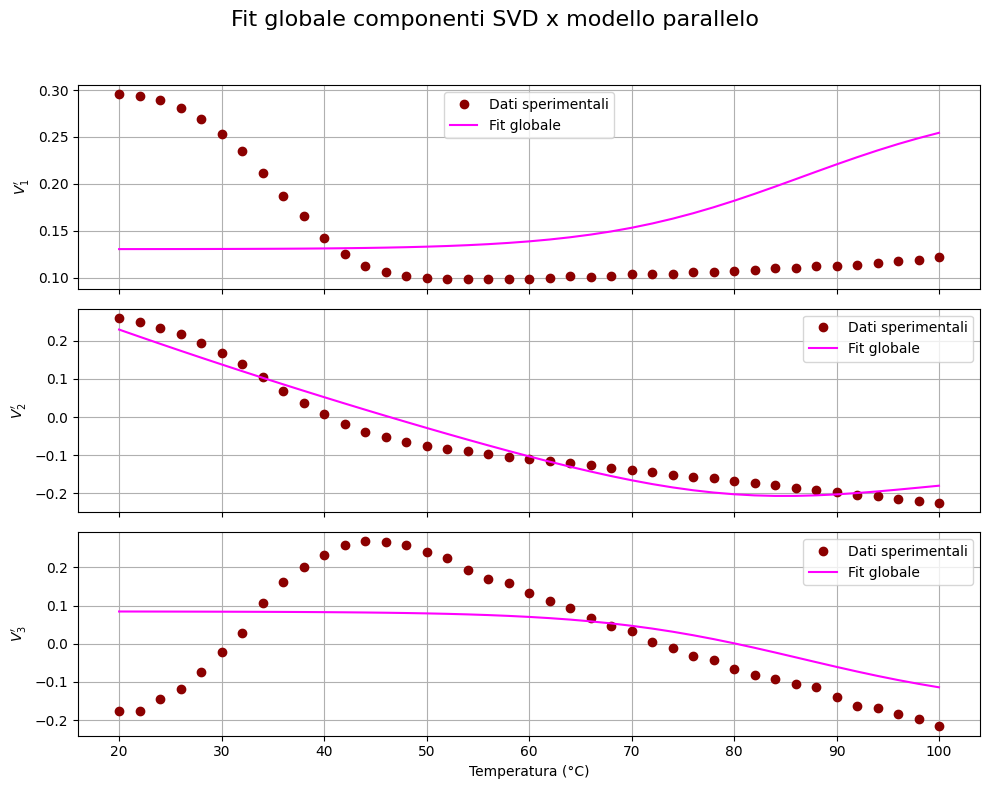


Chi quadro ridotto: 0.00855


In [51]:
Tm1, Tm2, dH1, dH2 = res_p.x[:4]
C12, C22, C23, C32, C21 = res_p.x[4:]

# ricostruzione della matrice C
C_opt = np.array([
    [C_fix['C11'], C12,  C_fix['C13']],
    [C21,          C22,  C23],
    [C_fix['C31'], C32,  C_fix['C33']]
])

# calcolo delle M con le T usate nel fit
M_opt_p_p = calc_M_2p(T_kelvin, Tm1, Tm2, dH1, dH2)
f_pred_p = C_opt @ M_opt_p_p  # shape (3, len(T))

# Calcolo chi quadro ridotto
residuals_p = V_prime - f_pred_p
chi2_p = np.sum(residuals_p**2) # somma dei residui al quadrato
dof = V_prime.size - len(res_p.x)  # gradi di libertà
chi2_red_p = chi2_p / dof # chi quadro ridotto

# Plot
fig, axs = plt.subplots(3, 1, figsize=(10, 8), sharex=True)
labels = [r"$V_1'$", r"$V_2'$", r"$V_3'$"]

for i in range(3):
    axs[i].plot(t_array, V_prime[i], 'o', label='Dati sperimentali', color='darkred')
    axs[i].plot(t_array, f_pred_p[i], '-', label='Fit globale', color='magenta')
    axs[i].set_ylabel(labels[i])
    axs[i].grid(True)
    axs[i].legend()

axs[2].set_xlabel("Temperatura (°C)")
plt.suptitle(r"Fit globale componenti SVD x modello parallelo", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
print(f"\nChi quadro ridotto: {chi2_red_p:.5f}")

Di seguito, invece, si considera di fittare per il modello F1<->U<->F2. (anche se impossibile secondo me?)

In [41]:
def calc_M_2s(T, Tm1, Tm2, dH1, dH2):
    T = np.clip(T, 273, 400)  # limita T tra 273 e 400 K
    # calcolo M_i(T) per i tre stati
    A = np.exp(-dH1 / R * (1/Tm1 - 1/T))
    B = np.exp(-dH2 / R * (1/Tm2 - 1/T))
    denom = 1 + A + B
    M1 = 1 / denom
    M2 = A / denom
    M3 = B / denom
    return np.stack([M1, M2, M3], axis=0)  # shape (3, len(T))


def residui_s(params, T, V_prime, C_fix):
    # unpack parametri liberi
    Tm1, Tm2, dH1, dH2 = params[:4]
    C12, C22, C23, C32, C21 = params[4:]

    # ricostruisci tutti i Cij
    C = np.array([
        [C_fix['C11'], C12,  C_fix['C13']],
        [C21,          C22,  C23],
        [C_fix['C31'], C32,  C_fix['C33']]
    ])  # shape (3, 3)

    # calcolo le M_i(T)
    M = calc_M_2s(T, Tm1, Tm2, dH1, dH2)  # shape (3, len(T))

    # calcolo f_i(T) = sum_j C_ij * M_j(T)
    f_pred = C @ M  # shape (3, len(T))

    # flatten dei residui
    return (V_prime - f_pred).flatten()


residui_init = residui_s(p0, T_kelvin, V_prime, C_fix)
print("Valori iniziali dei residui:", residui_init[:10])
print("Contengono NaN?", np.any(np.isnan(residui_init)))
print("Contengono inf?", np.any(np.isinf(residui_init)))


res_s = least_squares(
    residui_s,
    p0,
    args=(T_kelvin, V_prime, C_fix),
    method='trf'
)

# Stampa formattata dei parametri ottimizzati
param_labels = ['Tm1', 'Tm2', 'ΔH1', 'ΔH2', 'C12', 'C22', 'C23', 'C32', 'C21']
param_units = ['K', 'K', 'cal/mol', 'cal/mol', '', '', '', '', '']

print("\nParametri ottimizzati:")
for label, unit, value in zip(param_labels, param_units, res_s.x):
    print(f"{label:>4} = {value:10.2f} {unit}")

Valori iniziali dei residui: [0.17087279 0.16956469 0.16473018 0.1557257  0.14417421 0.12828538
 0.11001254 0.08638428 0.06218489 0.04049808]
Contengono NaN? False
Contengono inf? False

Parametri ottimizzati:
 Tm1 =     346.08 K
 Tm2 =     314.65 K
 ΔH1 =   18336.39 cal/mol
 ΔH2 =   72592.16 cal/mol
 C12 =       0.06 
 C22 =      -0.03 
 C23 =       0.27 
 C32 =       0.26 
 C21 =      -0.25 


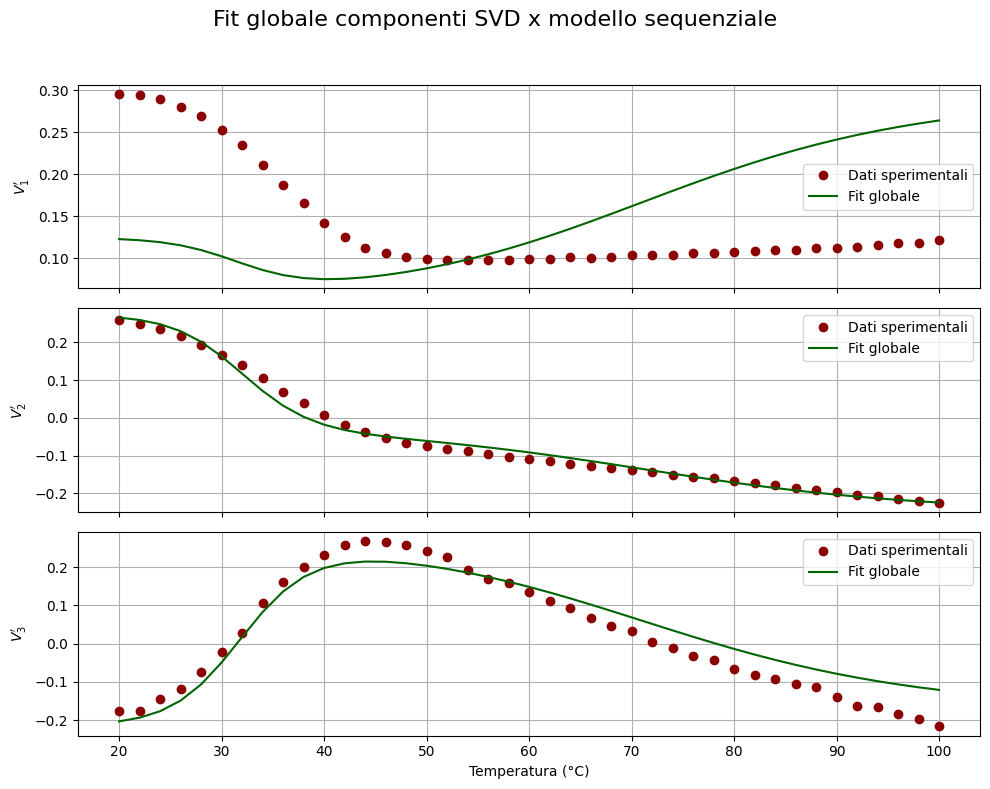


Chi quadro ridotto: 0.00466


In [52]:
Tm1, Tm2, dH1, dH2 = res_s.x[:4]
C12, C22, C23, C32, C21 = res_s.x[4:]

# ricostruzione della matrice C
C_opt = np.array([
    [C_fix['C11'], C12,  C_fix['C13']],
    [C21,          C22,  C23],
    [C_fix['C31'], C32,  C_fix['C33']]
])

# calcolo delle M con le T usate nel fit
M_opt_s = calc_M_2s(T_kelvin, Tm1, Tm2, dH1, dH2)
f_pred_s = C_opt @ M_opt_s  # shape (3, len(T))

# Calcolo chi quadro ridotto
residuals_s = V_prime - f_pred_s
chi2_s = np.sum(residuals_s**2) # somma dei residui al quadrato
dof = V_prime.size - len(res_s.x)  # gradi di libertà
chi2_red_s = chi2_s / dof # chi quadro ridotto

# Plot
fig, axs = plt.subplots(3, 1, figsize=(10, 8), sharex=True)
labels = [r"$V_1'$", r"$V_2'$", r"$V_3'$"]

for i in range(3):
    axs[i].plot(t_array, V_prime[i], 'o', label='Dati sperimentali', color='darkred')
    axs[i].plot(t_array, f_pred_s[i], '-', label='Fit globale', color='darkgreen')
    axs[i].set_ylabel(labels[i])
    axs[i].grid(True)
    axs[i].legend()

axs[2].set_xlabel("Temperatura (°C)")
plt.suptitle(r"Fit globale componenti SVD x modello sequenziale", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
print(f"\nChi quadro ridotto: {chi2_red_s:.5f}")

Per ultima cosa confrontiamo visivamente i due fit per capire (anche se risulta già chiaro) quale modello si adatta in maniera migliore al caso in esame

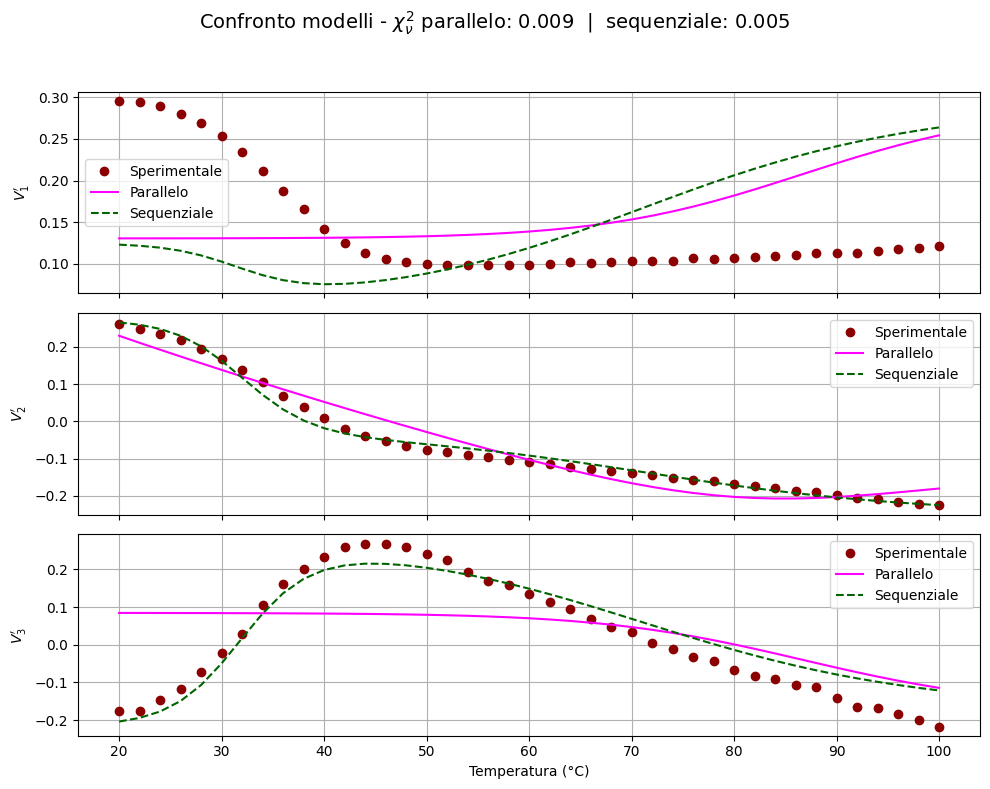

In [49]:
# Grafico comparativo dei due modelli
fig, axs = plt.subplots(3, 1, figsize=(10, 8), sharex=True)
labels = [r"$V_1'$", r"$V_2'$", r"$V_3'$"]

for i in range(3):
    axs[i].plot(t_array, V_prime[i], 'o', label='Sperimentale', color='darkred')
    axs[i].plot(t_array, f_pred_p[i], '-', label='Parallelo', color='magenta')
    axs[i].plot(t_array, f_pred_s[i], '--', label='Sequenziale', color='darkgreen')
    axs[i].set_ylabel(labels[i])
    axs[i].grid(True)
    axs[i].legend(loc='best')

axs[2].set_xlabel("Temperatura (°C)")
plt.suptitle(
    rf"Confronto modelli - $\chi^2_\nu$ parallelo: {chi2_red_p:.3f}  |  sequenziale: {chi2_red_s:.3f}",
    fontsize=14
)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
